# Soccer Predictions

This is a notebook to iterate through models

### Imports
This includes importing data using script: [./scripts/data_retrieval.py](./scripts/data_retrieval.py)
This is where feature engineering will occur

In [53]:
from collections import defaultdict

from scripts.data_retrieval import get_data

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_df = get_data()

# get dummies for each of the types of free kick that happened in the last 30 sec
dummies =  pd.get_dummies(data_df['free_kick_30s_ago'], drop_first=True)
dummies.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)
data_df = pd.merge(data_df,dummies, left_index=True, right_index=True)
data_df['free_kick_30s_ago'] = data_df['free_kick_30s_ago'].apply(bool)
# get a numeric version for the target
data_df['goal'] =  data_df['101']* 1
target = 'goal'

In [3]:
pre_filter = len(data_df)

# filter for all shots in the attacking half
filtered_df = data_df[data_df['x1'] > 50]
post_filter = len(filtered_df)

1-post_filter/pre_filter

0.0025209859856298866

In [4]:
train_val_df, test_df = train_test_split(filtered_df, shuffle=True, random_state=1950, test_size=.2)

train_df, val_df = train_test_split(train_val_df, shuffle=True, random_state=2020, test_size=.25)



In [5]:
# get standard scaling for distances and angles in training set
dist_scaler = StandardScaler().fit(train_df[['distance_to_goal_mid']])
ang_scaler = StandardScaler().fit(train_df[['angular_size_rad_goal']])

train_df['dist_std'] = dist_scaler.transform(train_df[['distance_to_goal_mid']].values)
train_df['ang_std'] = ang_scaler.transform(train_df[['angular_size_rad_goal']].values)
val_df['dist_std'] = dist_scaler.transform(val_df[['distance_to_goal_mid']].values)
val_df['ang_std'] = ang_scaler.transform(val_df[['angular_size_rad_goal']].values)

# also set scaling for whole training set including validation
dist_scaler_final = StandardScaler().fit(train_val_df[['distance_to_goal_mid']])
ang_scaler_final = StandardScaler().fit(train_val_df[['angular_size_rad_goal']])

train_val_df['dist_std'] = dist_scaler_final.transform(train_val_df[['distance_to_goal_mid']].values)
train_val_df['ang_std'] = ang_scaler_final.transform(train_val_df[['angular_size_rad_goal']].values)
test_df['dist_std'] = dist_scaler_final.transform(test_df[['distance_to_goal_mid']].values)
test_df['ang_std'] = ang_scaler_final.transform(test_df[['angular_size_rad_goal']].values)


/Users/bren_top/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/bren_top/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/bren_top/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

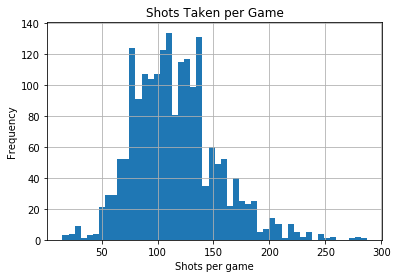

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
grouped = data_df[['matchId','eventName']].groupby('matchId').count()
grouped.hist(bins=50, ax=ax)
plt.title('Shots Taken per Game')
plt.xlabel('Shots per game')
plt.ylabel('Frequency');

## Baseline Model
- Model using distance to goal

In [7]:
y = train_df[target]
y_true_val = val_df[target]

In [8]:
features_1 = ['distance_to_goal_mid']
X = train_df[features_1]

logis_mod_1 = LogisticRegression(C=1000)
logis_fit_1 =  logis_mod_1.fit(X,y)

y_pred_proba_train_1 = logis_fit_1.predict_proba(train_df[features_1])
y_pred_proba_val_1 = logis_fit_1.predict_proba(val_df[features_1])
print('Max Predicted Probability {:.4}'.format(max(y_pred_proba_train_1[:,1])))

Max Predicted Probability 0.5177


optimal threshold    : 0.21
f1 score at threshold:  0.352


0.21

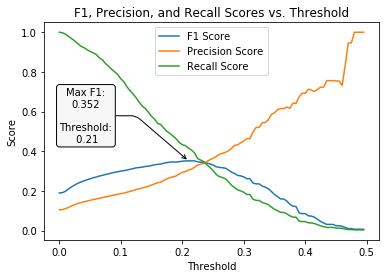

In [9]:
def plot_f1_over_thresholds(y_pred_proba, y_actual, threshold_range=None):
    try: 
        threshold_range.any()
    except AttributeError:
        threshold_range = np.arange(0,.5,.005)
    f1s = []
    precisions = []
    recalls = []
    for threshold in threshold_range:
        y_pred_loop = y_pred_proba > threshold
        f1s.append(f1_score(y_actual, y_pred_loop, pos_label=True))
        precisions.append(precision_score(y_actual, y_pred_loop, pos_label=True))
        recalls.append(recall_score(y_actual, y_pred_loop, pos_label=True))
    plt.plot(threshold_range, f1s, label='F1 Score')
    plt.plot(threshold_range, precisions, label='Precision Score')
    plt.plot(threshold_range, recalls, label='Recall Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('F1, Precision, and Recall Scores vs. Threshold')
    plt.legend()
    ind = np.argmax(f1s)
    max_f1 = f1s[ind]
    optimal_threshold = threshold_range[ind]
    note = f'Max F1:\n{max_f1:.3}\n\nThreshold:\n{optimal_threshold: .3}'
    plt.annotate(note, xy=[optimal_threshold, max_f1], xycoords='data', 
                 xytext=(0.125, 0.45), textcoords='axes fraction',
                 ha="center",
                 bbox=dict(boxstyle="round", fc="0.97"),
                 arrowprops=dict(arrowstyle="->",
                                 shrinkA=0, shrinkB=2,
                                 connectionstyle="arc,angleA=0,armA=50,rad=5"))
    return max_f1, optimal_threshold 

opt_f1_1, opt_threshold_1 = plot_f1_over_thresholds(y_pred_proba_train_1[:,1], y)
print(f'optimal threshold    :{opt_threshold_1: .4}\nf1 score at threshold: {opt_f1_1: .3}')

opt_threshold_1

In [10]:
logis_fit_1.coef_[0][0]

-0.13192897227571931

#### Validatian Score:

In [11]:
y_pred_val_1 = y_pred_proba_val_1[:,1] > opt_threshold_1
print(classification_report(y_true_val, y_pred_val_1))
print(f1_score(y_true_val, y_pred_val_1))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     40263
           1       0.29      0.41      0.34      4606

    accuracy                           0.84     44869
   macro avg       0.61      0.65      0.62     44869
weighted avg       0.86      0.84      0.85     44869

0.3403445149592022


/Users/bren_top/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


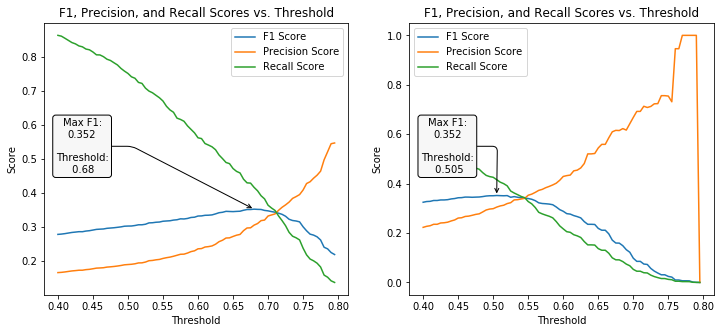

In [12]:
lr_balanceed = LogisticRegression(class_weight='balanced', C=1000)
lr_4x = LogisticRegression(class_weight={True : 4, False : 1}, C=1000)
fit_balanced = lr_balanceed.fit(X,y)
fit_4x = lr_4x.fit(X,y)

y_proba_train_balanced = fit_balanced.predict_proba(X)
y_proba_train_4x = fit_4x.predict_proba(X)

y_proba_val_balanced = fit_balanced.predict_proba(val_df[features_1])
y_proba_val_4x = fit_4x.predict_proba(val_df[features_1])


plt.figure(figsize=[12,5])
plt.subplot(121)
opt_f1_balanced, opt_threshold_balanced = plot_f1_over_thresholds(y_proba_train_balanced[:,1], y, np.arange(.4,.8,.005))
plt.subplot(122)
opt_f1_4x, opt_threshold_4x = plot_f1_over_thresholds(y_proba_train_4x[:,1], y, np.arange(.4,.8,.005))

## Feature Engineering






#### Spatial Features
| Feature                       | Description
|:------------------------------|:------------------------------------|
| distance_to_goal_mid          | distance to goal in yards <br> ***see below for details***  |
| distance_to_goal_nearest      |    |
| angular_size_rad_goal         | angular size of the goal in radians <br> ***see below for details*** <br> Although pictured below is in degrees, the computed value is in radians |
| projected_size_yds_goal       | a projection of the size of the goal in yards <br> ***see below for details*** <br>(an attempt to more linearly separate angular size from distance to goal)|
|   kicked                      | whether the ball was kicked or headed
   side_of_field_matching_foot | whether the foot used matched the side of the field|
   
<img src="./extras/feature_geometries.png" width="1000" style="display: block; margin-left: auto; margin-right: auto; width: 75%;">

<div align="center"> Generated in <a href="https://www.geogebra.org/">geogebra</a> </div>


#### Temporal Features
| Feature                       | Description
|:------------------------------|:------------------------------------|
|   send_off_diff               | the cumulative player advantage due to send offs|
|   free_kick_30s_ago           | The type of free kick if one happened less than 30s ago|


#### Additional Features
| Feature                       | Description
|:------------------------------|:------------------------------------|
|   dominant foot               | cross references a data base of player information to tell whether the dominant foot was used|

### Comparison of Angular Size vs Projected Size

Both of these ended up not helping the logistic regrossion very much and aren't any better alone. The both are skewed data sets with one being skewed towards the smaller end, the other skewed towards higher end

8168/134607 =  6.07%


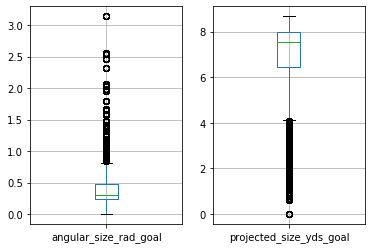

In [13]:
plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
train_df[['angular_size_rad_goal']].boxplot(ax=ax1)
train_df[['projected_size_yds_goal']].boxplot(ax=ax2)
# plt.ylim([0,200])
above_8 = sum(train_df['projected_size_yds_goal'] > 8)
total = len(train_df)
print(f"{above_8}/{total} = {above_8/total: .2%}")

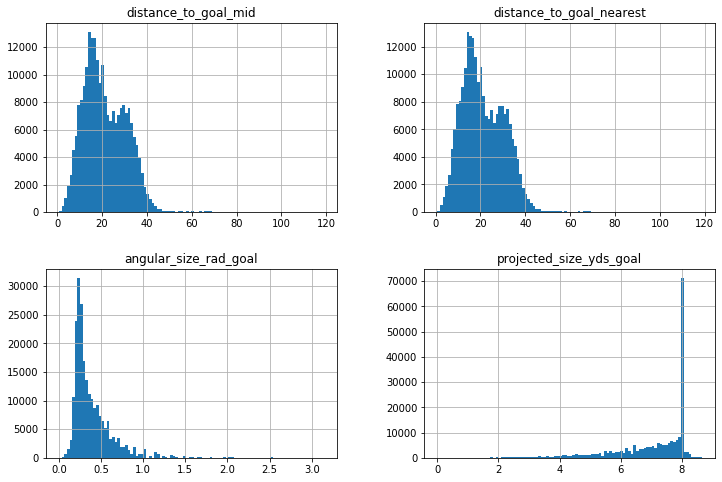

In [14]:
features_to_plot = ['distance_to_goal_mid', 'distance_to_goal_nearest', 'angular_size_rad_goal', 'projected_size_yds_goal']
plt.figure(figsize=[12,8])
for ind, feature in enumerate(features_to_plot):
    ax = plt.subplot(2, 2, ind + 1)
    # diff = int(data_df[feature].values.max() -  data_df[feature].values.min())
    data_df[[feature]].hist(bins=100, ax=ax)

Max Predicted Probability 0.9436
optimal threshold    : 0.3561
f1 score at threshold:  0.195


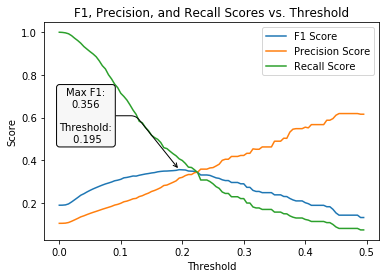

In [15]:
features_2 = ['distance_to_goal_mid', 'angular_size_rad_goal']
X_2 = train_df[features_2]
scaler_2 = StandardScaler()
X_std_sc = scaler_2.fit_transform(X_2)
X_val_std_sc = scaler_2.transform(val_df[features_2])

logis_mod_2 = LogisticRegression(C=1000)
logis_fit_2 =  logis_mod_2.fit(X_std_sc,y)

y_pred_proba_train_2 = logis_fit_2.predict_proba(X_std_sc)
y_pred_proba_val_2 = logis_fit_2.predict_proba(X_val_std_sc)
print('Max Predicted Probability {:.4}'.format(max(y_pred_proba_train_2[:,1])))
opt_threshold_2, opt_f1_2 = plot_f1_over_thresholds(y_pred_proba_train_2[:,1], y)
print(f'optimal threshold    :{opt_threshold_2: .4}\nf1 score at threshold: {opt_f1_2: .3}')

In [16]:
logis_fit_2.coef_ / scaler_2.scale_


array([[-0.08625587,  1.30812598]])

Max Predicted Probability 0.5299
optimal threshold    : 0.225
f1 score at threshold:  0.354


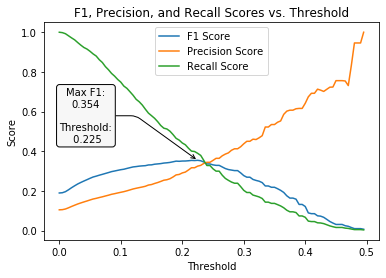

In [17]:
features_3 = ['distance_to_goal_mid', 'projected_size_yds_goal']
X_3 = train_df[features_3]
scaler_3 = StandardScaler()
X_std_sc_3 = scaler_3.fit_transform(X_3)
X_val_std_sc_3 = scaler_3.transform(val_df[features_3])


logis_mod_3 = LogisticRegression(C=1000)
logis_fit_3 =  logis_mod_3.fit(X_std_sc_3,y)

y_pred_proba_train_3 = logis_fit_3.predict_proba(X_std_sc_3)
y_pred_proba_val_3 = logis_fit_3.predict_proba(X_val_std_sc_3)
print('Max Predicted Probability {:.4}'.format(max(y_pred_proba_train_3[:,1])))
opt_f1_3, opt_threshold_3 = plot_f1_over_thresholds(y_pred_proba_train_3[:,1], y)
print(f'optimal threshold    :{opt_threshold_3: .4}\nf1 score at threshold: {opt_f1_3: .3}')

In [18]:
logis_fit_3.coef_ / scaler_3.scale_

array([[-0.12789106,  0.11905751]])

Max Predicted Probability 0.1355


/Users/bren_top/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


optimal threshold    : 0.12
f1 score at threshold:  0.238


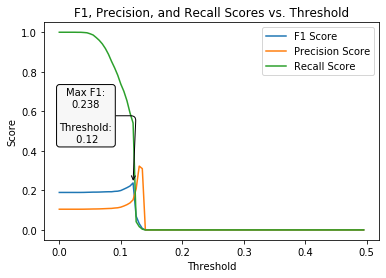

In [19]:
features_4 = ['projected_size_yds_goal']
X_4 = train_df[features_4]
scaler_4 = StandardScaler()
X_std_sc_4 = scaler_4.fit_transform(X_4)
X_val_std_sc_4 = scaler_4.transform(val_df[features_4])

logis_mod_4 = LogisticRegression(C=1000)
logis_fit_4 =  logis_mod_4.fit(X_std_sc_4,y)

y_pred_proba_train_4 = logis_fit_4.predict_proba(X_std_sc_4)
y_pred_proba_val_4 = logis_fit_4.predict_proba(X_val_std_sc_4)
print('Max Predicted Probability {:.4}'.format(max(y_pred_proba_train_4[:,1])))
opt_f1_4, opt_threshold_4 = plot_f1_over_thresholds(y_pred_proba_train_4[:,1], y)
print(f'optimal threshold    :{opt_threshold_4: .4}\nf1 score at threshold: {opt_f1_4: .3}')

In [20]:
logis_fit_4.coef_ / scaler_4.scale_

array([[0.19032195]])

Max Predicted Probability 0.998
optimal threshold    : 0.14
f1 score at threshold:  0.346


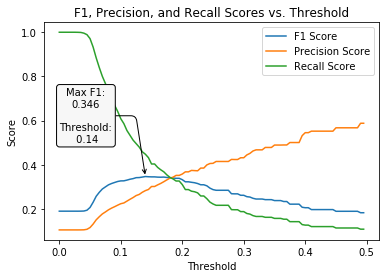

In [21]:
features_5 = ['angular_size_rad_goal']
X_5 = train_df[features_5]
scaler_5 = StandardScaler()
X_std_sc_5 = scaler_5.fit_transform(X_5)
X_val_std_sc_5 = scaler_5.transform(val_df[features_5])

logis_mod_5 = LogisticRegression(C=1000)
logis_fit_5 =  logis_mod_5.fit(X_std_sc_5,y)

y_pred_proba_train_5 = logis_fit_5.predict_proba(X_std_sc_5)
y_pred_proba_val_5 = logis_fit_5.predict_proba(X_val_std_sc_5)
print('Max Predicted Probability {:.4}'.format(max(y_pred_proba_train_5[:,1])))
opt_f1_5, opt_threshold_5 = plot_f1_over_thresholds(y_pred_proba_train_5[:,1], y)
print(f'optimal threshold    :{opt_threshold_5: .4}\nf1 score at threshold: {opt_f1_5: .3}')

## Logistic Modeling on the Whole Feature Set

On the whole this performed worse (in terms of predictive power) than the tree based methods but the goal is interpretability

/Users/bren_top/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Max Predicted Probability 1.0
optimal threshold    : 0.32
f1 score at threshold:  0.364


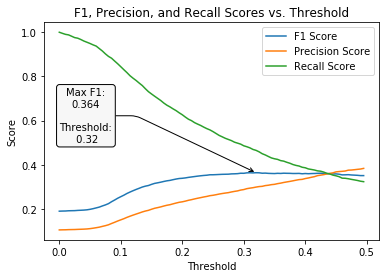

In [22]:
features_all = [
       'distance_to_goal_mid',
       'angular_size_rad_goal', 'kicked', 'side_of_field_matching_foot',
       'send_off_diff', 'dominant_foot', 'corner',
       'free_kick', 'free_kick_cross', 'free_kick_shot', 'goal_kick',
       'penalty', 'throw_in']

X_train_all = train_df[features_all]
scaler_all = StandardScaler()
X_std_sc_all = scaler_all.fit_transform(X_train_all)
X_val_std_sc_all = scaler_all.transform(val_df[features_all])


logis_mod_all = LogisticRegression(C=1000)
logis_fit_all =  logis_mod_5.fit(X_train_all,y)

y_pred_proba_train_all = logis_fit_all.predict_proba(X_std_sc_all)
y_pred_proba_val_all = logis_fit_all.predict_proba(X_val_std_sc_all)
print('Max Predicted Probability {:.4}'.format(max(y_pred_proba_train_all[:,1])))
opt_f1_all, opt_threshold_all = plot_f1_over_thresholds(y_pred_proba_train_all[:,1], y)
print(f'optimal threshold    :{opt_threshold_all: .4}\nf1 score at threshold: {opt_f1_all: .3}')

In [23]:
logis_fit_all.coef_ / scaler_all.scale_

array([[-0.01134923,  6.04293604,  2.63040927,  0.01569448, -0.06847843,
        -0.04839531, -0.33341312,  0.11406406, -0.41427078, -4.4575929 ,
         0.55626104,  3.32361762, -0.26980317]])

In [24]:
train_df[['goal']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134607 entries, 336 to 969
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   goal    134607 non-null  int64
dtypes: int64(1)
memory usage: 2.1 MB


### A Deeper Dive
statsmodels has slightly different results in the smaller coefficients but match pretty closely especially for the larger values.
Features to eliminate:
 - send_off_diff : the p value is >> .5
 - dominant_foot : the p value is >> .5

In [25]:
features_std = [
       'dist_std',
       'ang_std', 'kicked', 'side_of_field_matching_foot',
       'send_off_diff', 'dominant_foot', 'corner',
       'free_kick', 'free_kick_cross', 'free_kick_shot', 'goal_kick',
       'penalty', 'throw_in']

features_formula = " + ".join(features_std)
model_string = " ~ ".join([target, features_formula])
fit_sm = smf.logit(model_string, train_df).fit()
fit_sm.summary()

Optimization terminated successfully.
         Current function value: 0.282354
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   goal   No. Observations:               134607
Model:                          Logit   Df Residuals:                   134593
Method:                           MLE   Df Model:                           13
Date:                Wed, 05 Aug 2020   Pseudo R-squ.:                  0.1580
Time:                        03:32:07   Log-Likelihood:                -38007.
converged:                       True   LL-Null:                       -45138.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.3912      0.028   -119.043      0.000      -3.447      -3.335
dist_std                       -0.9582      0.020    -46.964      0.000      -0.998      -0.918
ang_std                         0.3553      0.013     28.345      0.000       0.331       0.380
kicked                          0.9710      0.034     28.641      0.000       0.905       1.037
side_of_field_matching_foot     0.0136      0.012      1.141      0.254      -0.010       0.037
send_off_diff                  -0.0299      0.021     -1.420      0.156      -0.071       0.011
dominant_foot                  -0.0259      0.025     -1.054      0.292      -0.074       0.022
corner                         -0.1118      0.030     -3.766      0.000      -0.170      -0.054
free_kick                       0.0343      0.035      0.980      0.327      -0.034       0.103
free_kick_cross                -0.0961      0.044     -2.190      0.029      -0.182      -0.010
free_kick_shot                 -0.3897      0.122     -3.186      0.001      -0.629      -0.150
goal_kick                       0.1060      0.049      2.176      0.030       0.011       0.201
penalty                         0.2308      0.197      1.172      0.241      -0.155       0.617
throw_in                       -0.0999      0.028     -3.585      0.000      -0.154      -0.045
===============================================================================================
"""

## Finalizing the Model

In [26]:
features_downselect = [
    'dist_std', 'ang_std', 'kicked', 
    'side_of_field_matching_foot',
    'corner', 'free_kick', 'free_kick_cross', 
    'free_kick_shot', 'goal_kick',
    'penalty', 'throw_in']
features_formula = " + ".join(features_downselect)
model_string = " ~ ".join([target, features_formula])
fit_sm = smf.logit(model_string, train_df).fit()
fit_sm.summary()

Optimization terminated successfully.
         Current function value: 0.282365
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   goal   No. Observations:               134607
Model:                          Logit   Df Residuals:                   134595
Method:                           MLE   Df Model:                           11
Date:                Wed, 05 Aug 2020   Pseudo R-squ.:                  0.1580
Time:                        03:32:08   Log-Likelihood:                -38008.
converged:                       True   LL-Null:                       -45138.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.3926      0.028   -119.183      0.000      -3.448      -3.337
dist_std                       -0.9580      0.020    -46.958      0.000      -0.998      -0.918
ang_std                         0.3553      0.013     28.343      0.000       0.331       0.380
kicked                          0.9939      0.026     38.418      0.000       0.943       1.045
side_of_field_matching_foot     0.0142      0.012      1.184      0.236      -0.009       0.038
corner                         -0.1111      0.030     -3.744      0.000      -0.169      -0.053
free_kick                       0.0343      0.035      0.980      0.327      -0.034       0.103
free_kick_cross                -0.0958      0.044     -2.183      0.029      -0.182      -0.010
free_kick_shot                 -0.3890      0.122     -3.180      0.001      -0.629      -0.149
goal_kick                       0.1058      0.049      2.172      0.030       0.010       0.201
penalty                         0.2311      0.197      1.173      0.241      -0.155       0.617
throw_in                       -0.0997      0.028     -3.579      0.000      -0.154      -0.045
===============================================================================================
"""

optimal threshold    : 0.175
f1 score at threshold:  0.372


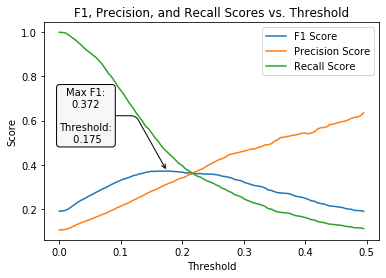

In [27]:
y_train_proba = fit_sm.predict(train_df[features_downselect])

opt_f1_ds, opt_threshold_ds = plot_f1_over_thresholds(y_train_proba, y)
print(f'optimal threshold    :{opt_threshold_ds: .4}\nf1 score at threshold: {opt_f1_ds: .3}')

In [28]:
y_val_proba = fit_sm.predict(val_df[features_downselect])
y_val_pred = y_val_proba > opt_threshold_ds

val_f1 = f1_score(y_true_val, y_val_pred)
print(f'Validation F1 Score: {val_f1: .3f}')

Validation F1 Score:  0.366


## Final training on whole training set to get test score

In [29]:
fit_sm_final = smf.logit(model_string, train_val_df).fit()
fit_sm_final.summary()

Optimization terminated successfully.
         Current function value: 0.281892
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   goal   No. Observations:               179476
Model:                          Logit   Df Residuals:                   179464
Method:                           MLE   Df Model:                           11
Date:                Wed, 05 Aug 2020   Pseudo R-squ.:                  0.1566
Time:                        03:32:23   Log-Likelihood:                -50593.
converged:                       True   LL-Null:                       -59985.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.4000      0.025   -137.406      0.000      -3.448      -3.351
dist_std                       -0.9434      0.018    -53.560      0.000      -0.978      -0.909
ang_std                         0.3603      0.011     33.175      0.000       0.339       0.382
kicked                          1.0029      0.023     44.516      0.000       0.959       1.047
side_of_field_matching_foot     0.0156      0.010      1.508      0.132      -0.005       0.036
corner                         -0.1150      0.026     -4.463      0.000      -0.166      -0.065
free_kick                       0.0360      0.030      1.187      0.235      -0.023       0.095
free_kick_cross                -0.0960      0.038     -2.520      0.012      -0.171      -0.021
free_kick_shot                 -0.3515      0.105     -3.357      0.001      -0.557      -0.146
goal_kick                       0.1055      0.042      2.503      0.012       0.023       0.188
penalty                         0.2641      0.170      1.556      0.120      -0.069       0.597
throw_in                       -0.0972      0.024     -4.024      0.000      -0.145      -0.050
===============================================================================================
"""

optimal threshold    : 0.175
f1 score at threshold:  0.37


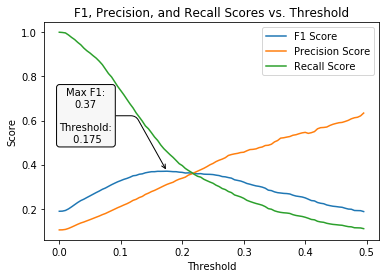

In [30]:
y_proba = fit_sm.predict(train_val_df[features_downselect])
y_train_val = train_val_df[target]
opt_f1_final, opt_threshold_final = plot_f1_over_thresholds(y_proba, y_train_val)
print(f'optimal threshold    :{opt_threshold_final: .4}\nf1 score at threshold: {opt_f1_final: .3}')

In [31]:
y_proba = fit_sm.predict(test_df[features_downselect])
y_pred = y_val_proba > opt_threshold_final
y_test = test_df[target]

test_f1 = f1_score(y_test, y_pred)
print(f'Test F1 Score: {test_f1: .3f}')

Test F1 Score:  0.129


### Some interesting test points
1. medium far shot
<img src="./extras/big_angle_mid.png" width="1000" style="display: block; margin-left: auto; margin-right: auto; width: 75%;">

<div align="center"> Generated in <a href="https://www.geogebra.org/">geogebra</a> </div>

2. far shot
<img src="./extras/small_angle_mid.png" width="1000" style="display: block; margin-left: auto; margin-right: auto; width: 75%;">

<div align="center"> Generated in <a href="https://www.geogebra.org/">geogebra</a> </div>


3. same angle as the previous shot but the same distance as the first
<img src="./extras/small_angle_side.png" width="1000" style="display: block; margin-left: auto; margin-right: auto; width: 75%;">

<div align="center"> Generated in <a href="https://www.geogebra.org/">geogebra</a> </div>


4. same angle as the first but closer (not in the center)
<img src="./extras/big_angle_side.png" width="1000" style="display: block; margin-left: auto; margin-right: auto; width: 75%;">

<div align="center"> Generated in <a href="https://www.geogebra.org/">geogebra</a> </div>

5. From 12 yards out center of goal (penalty spot)

6. From 6 yards out center of goal (goal box)

7. From 4 yards out center of goal

8. Wondo's shot in the world cup
<img src="https://64.media.tumblr.com/c4561c9e8c9e87c5b7fea376f1c95472/tumblr_n82rypxL8S1qcrctyo1_500.gif" width="1000" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">
<div align="center"> Source <a href="https://ftw.usatoday.com/2017/04/this-chris-wondolowski-miss-mls-world-cup-2014-video-san-jose">USA Today</a> </div>


<img src="./extras/wondo_world_cup.png" width="1000" style="display: block; margin-left: auto; margin-right: auto; width: 75%;">

<div align="center"> Generated in <a href="https://www.geogebra.org/">geogebra</a> </div>


In [32]:
distances = 1 - (np.array([18, 18, 24.71, 15.3304, 12, 6, 4, 7]).reshape(-1,1)/120 )
angles_rad = np.array([25.0576, 18.3903, 18.3903, 25.0576, 36.8699, 67.3801, 90, 55.2]).reshape(-1,1) * np.pi/180

test_points = pd.DataFrame(np.zeros([len(distances), len(features_downselect)]), columns=features_downselect)

test_points.loc[7, 'kicked'] = 1
test_points.loc[7, 'side_of_field_matching_foot'] = 1
test_points.loc[7, 'throw_in'] = 1


dist_std_syn = dist_scaler.transform(distances)
ang_std_syn = ang_scaler.transform(angles_rad)

test_points['dist_std'] = dist_std_syn
test_points['ang_std'] = ang_std_syn

fit_sm_final.predict(test_points)

0    0.225368
1    0.196598
2    0.197506
3    0.224970
4    0.282273
5    0.463439
6    0.607984
7    0.612891
dtype: float64

# Appendices

In [33]:
summaries = []
for feature in features_all:
    fit_sm = smf.logit(f'goal ~ {feature}', train_df).fit()
    summaries.append(fit_sm.summary())

Optimization terminated successfully.
         Current function value: 0.291722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335277
  

## Non Linear Models
 - Random Forest
 - adaboost
 - Extra Trees

While Non Linear Models did increase pridictive power ultimately a linear model was chosen for its interpretability

In [34]:
features_nl = [
       'distance_to_goal_mid',
       'angular_size_rad_goal', 'kicked', 'side_of_field_matching_foot',
       'send_off_diff', 'dominant_foot', 'corner',
       'free_kick', 'free_kick_cross', 'free_kick_shot', 'goal_kick',
       'penalty', 'throw_in']
features_continuous = ['distance_to_goal_mid',
       'distance_to_goal_nearest', 'angular_size_rad_goal',
       'projected_size_yds_goal']
features_discrete = ['kicked', 'side_of_field_matching_foot',
       'send_off_diff', 'dominant_foot', 'corner',
       'free_kick', 'free_kick_cross', 'free_kick_shot', 'goal_kick',
       'penalty', 'throw_in']

In [35]:
models = {'rand_forest': RandomForestClassifier, 'ada': AdaBoostClassifier, 'ex_trees': ExtraTreesClassifier}

In [36]:
folds = KFold(shuffle=True, random_state=919627)

In [37]:
fits =  {}
f1_scores_by_model = defaultdict(list)


for loop_ind, (train, val) in enumerate(folds.split(train_df)):  # 5 folds
    training_set = train_df.iloc[train]
    validation_set = train_df.iloc[val]
    X_ts = training_set[features_nl]
    y_ts = training_set[target]
    X_vs = validation_set[features_nl]
    y_vs = validation_set[target]
    for model in models.keys():  # 2 models
        fits[f'{model}_{loop_ind}'] = models[model]().fit(X_ts, y_ts)
        y_pred_ts = fits[f'{model}_{loop_ind}'].predict(X_ts)
        y_pred_vs = fits[f'{model}_{loop_ind}'].predict(X_vs)
        f1_scores_by_model[model + '_train'].append(f1_score(y_pred_ts, y_ts))
        f1_scores_by_model[model + '_val'].append(f1_score(y_pred_vs, y_vs))
        

In [38]:
print(f'Mean F1 Score Across {folds.get_n_splits()} folds')
for key in f1_scores_by_model.keys():
    mean = np.mean(f1_scores_by_model[key])
    std = np.std(f1_scores_by_model[key])
    print(f'{key:<20}: {mean: 6.3f} ± {std: 5.3f}')
    

Mean F1 Score Across 5 folds
rand_forest_train   :  0.563 ±  0.003
rand_forest_val     :  0.490 ±  0.005
ada_train           :  0.163 ±  0.012
ada_val             :  0.160 ±  0.011
ex_trees_train      :  0.551 ±  0.003
ex_trees_val        :  0.480 ±  0.005


In [39]:
rand_for = pd.DataFrame(index=features_nl)
ex_tree = pd.DataFrame(index=features_nl)
ada = pd.DataFrame(index=features_nl)
for key in fits.keys():
    impor = pd.Series(fits[key].feature_importances_, index=features_nl, name=key)
    if key.startswith('r'):
        print(key)
        rand_for[key] = impor
    elif key.startswith('e'):
        print(key)
        ex_tree[key] = impor
    else:
        print(key)
        ada[key] = impor

f_imp = pd.merge(rand_for, ada, left_index=True, right_index=True)
f_imp = pd.merge(f_imp, ex_tree, left_index=True, right_index=True)

rand_forest_0
ada_0
ex_trees_0
rand_forest_1
ada_1
ex_trees_1
rand_forest_2
ada_2
ex_trees_2
rand_forest_3
ada_3
ex_trees_3
rand_forest_4
ada_4
ex_trees_4


In [40]:
rand_for.sort_values('rand_forest_0', ascending=False).T.describe()

,distance_to_goal_mid,angular_size_rad_goal,send_off_diff,side_of_field_matching_foot,dominant_foot,corner,throw_in,free_kick,free_kick_cross,goal_kick,kicked,free_kick_shot,penalty
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.407345,0.386809,0.064542,0.023417,0.020371,0.017969,0.018734,0.017331,0.012676,0.011846,0.012057,0.004567,0.002337
std,0.006087,0.006525,0.002779,0.001207,0.001038,0.000554,0.001287,0.000548,0.000951,0.000526,0.000634,0.000300,0.000125
min,0.399124,0.377227,0.061455,0.021976,0.019135,0.017310,0.016893,0.016542,0.011675,0.010985,0.011388,0.004136,0.002114
25%,0.405005,0.384571,0.062670,0.022434,0.019359,0.017745,0.018182,0.017209,0.011773,0.011766,0.011546,0.004422,0.002372
50%,0.408136,0.388457,0.063725,0.023766,0.021005,0.017956,0.018923,0.017238,0.012683,0.011978,0.011914,0.004590,0.002391
75%,0.408572,0.388807,0.066915,0.023946,0.021016,0.018002,0.019357,0.017672,0.013615,0.012164,0.012652,0.004840,0.002398
max,0.415890,0.394982,0.067943,0.024961,0.021342,0.018830,0.020317,0.017994,0.013635,0.012336,0.012783,0.004847,0.002408


In [41]:
ada.sort_values('ada_0', ascending=False).T.describe()

,distance_to_goal_mid,angular_size_rad_goal,kicked,send_off_diff,corner,free_kick_cross,throw_in,side_of_field_matching_foot,dominant_foot,free_kick,free_kick_shot,goal_kick,penalty
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.00,5.000000,5.0,5.000000,5.000000,5.000000,5.0,5.0
mean,0.596000,0.272000,0.036000,0.028000,0.008000,0.02,0.016000,0.0,0.008000,0.008000,0.008000,0.0,0.0
std,0.029665,0.010954,0.008944,0.010954,0.010954,0.00,0.008944,0.0,0.010954,0.010954,0.010954,0.0,0.0
min,0.560000,0.260000,0.020000,0.020000,0.000000,0.02,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
25%,0.580000,0.260000,0.040000,0.020000,0.000000,0.02,0.020000,0.0,0.000000,0.000000,0.000000,0.0,0.0
50%,0.600000,0.280000,0.040000,0.020000,0.000000,0.02,0.020000,0.0,0.000000,0.000000,0.000000,0.0,0.0
75%,0.600000,0.280000,0.040000,0.040000,0.020000,0.02,0.020000,0.0,0.020000,0.020000,0.020000,0.0,0.0
max,0.640000,0.280000,0.040000,0.040000,0.020000,0.02,0.020000,0.0,0.020000,0.020000,0.020000,0.0,0.0


In [42]:
ex_tree.sort_values('ex_trees_0', ascending=False).T.describe()

,distance_to_goal_mid,angular_size_rad_goal,send_off_diff,side_of_field_matching_foot,dominant_foot,throw_in,free_kick,corner,kicked,free_kick_cross,goal_kick,free_kick_shot,penalty
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.432149,0.429193,0.057996,0.017245,0.011909,0.008910,0.009382,0.008556,0.008195,0.006611,0.005786,0.002533,0.001534
std,0.006200,0.008836,0.002309,0.000655,0.000792,0.000781,0.000513,0.000506,0.000427,0.000781,0.000379,0.000340,0.000109
min,0.423079,0.419705,0.056458,0.016429,0.010743,0.008241,0.008700,0.007946,0.007437,0.005242,0.005207,0.002001,0.001405
25%,0.430381,0.420020,0.056609,0.016881,0.011735,0.008278,0.009177,0.008340,0.008336,0.006786,0.005592,0.002423,0.001485
50%,0.431571,0.431758,0.057363,0.017205,0.011767,0.008595,0.009311,0.008405,0.008360,0.006838,0.005998,0.002614,0.001487
75%,0.436658,0.436251,0.057504,0.017563,0.012611,0.009413,0.009661,0.008817,0.008363,0.007001,0.006057,0.002779,0.001628
max,0.439056,0.438232,0.062045,0.018149,0.012690,0.010023,0.010061,0.009273,0.008478,0.007188,0.006075,0.002848,0.001667


In [43]:
features_nl_2 = [
       'distance_to_goal_mid',
       'angular_size_rad_goal', 'kicked', 'side_of_field_matching_foot',
       'send_off_diff', 'dominant_foot', 'free_kick_30s_ago']

In [44]:
fits_2 =  {}
f1_scores_by_model_2 = defaultdict(list)


for loop_ind, (train, val) in enumerate(folds.split(train_df)):  # 5 folds
    training_set = train_df.iloc[train]
    validation_set = train_df.iloc[val]
    X_ts = training_set[features_nl]
    y_ts = training_set[target]
    X_vs = validation_set[features_nl]
    y_vs = validation_set[target]
    for model in models.keys():  # 2 models
        fits_2[f'{model}_{loop_ind}'] = models[model]().fit(X_ts, y_ts)
        y_pred_ts = fits[f'{model}_{loop_ind}'].predict(X_ts)
        y_pred_vs = fits[f'{model}_{loop_ind}'].predict(X_vs)
        f1_scores_by_model_2[model + '_train'].append(f1_score(y_pred_ts, y_ts))
        f1_scores_by_model_2[model + '_val'].append(f1_score(y_pred_vs, y_vs))
        

In [45]:
print(f'Mean F1 Score Across {folds.get_n_splits()} folds')
for key in f1_scores_by_model_2.keys():
    mean = np.mean(f1_scores_by_model_2[key])
    std = np.std(f1_scores_by_model_2[key])
    print(f'{key:<20}: {mean: 6.3f} ± {std: 5.3f}')

Mean F1 Score Across 5 folds
rand_forest_train   :  0.563 ±  0.003
rand_forest_val     :  0.490 ±  0.005
ada_train           :  0.163 ±  0.012
ada_val             :  0.160 ±  0.011
ex_trees_train      :  0.551 ±  0.003
ex_trees_val        :  0.480 ±  0.005


In [46]:
rand_for_2 = pd.DataFrame(index=features_nl)
ex_tree_2 = pd.DataFrame(index=features_nl)
ada_2 = pd.DataFrame(index=features_nl)
for key in fits.keys():
    impor = pd.Series(fits[key].feature_importances_, index=features_nl, name=key)
    if key.startswith('r'):
        print(key)
        rand_for_2[key] = impor
    elif key.startswith('e'):
        print(key)
        ex_tree_2[key] = impor
    else:
        print(key)
        ada_2[key] = impor

f_imp_2 = pd.merge(rand_for, ada, left_index=True, right_index=True)
f_imp_2 = pd.merge(f_imp_2, ex_tree, left_index=True, right_index=True)

rand_forest_0
ada_0
ex_trees_0
rand_forest_1
ada_1
ex_trees_1
rand_forest_2
ada_2
ex_trees_2
rand_forest_3
ada_3
ex_trees_3
rand_forest_4
ada_4
ex_trees_4


In [47]:
fits_features = {}
f1_scores_by_features = defaultdict(list)
for feature in features_all:
    print(f'Modeling: {feature}')
    for loop_ind, (train, val) in enumerate(folds.split(train_df)):  # 5 folds
        print(f'Cross Fold {loop_ind + 1} of 5')
        training_set = train_df.iloc[train]
        validation_set = train_df.iloc[val]
        X_ts = training_set[[feature]]
        y_ts = training_set[target]
        X_vs = validation_set[[feature]]
        y_vs = validation_set[target]
        fits_features[f'{feature}'] = RandomForestClassifier().fit(X_ts, y_ts)
        y_pred_ts = fits_features[f'{feature}'].predict(X_ts)
        y_pred_vs = fits_features[f'{feature}'].predict(X_vs)
        f1_scores_by_features[feature + '_train'].append(f1_score(y_pred_ts, y_ts))
        f1_scores_by_features[feature + '_val'].append(f1_score(y_pred_vs, y_vs))

Modeling: distance_to_goal_mid
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: angular_size_rad_goal
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: kicked
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: side_of_field_matching_foot
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: send_off_diff
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: dominant_foot
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: corner
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: free_kick
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling: free_kick_cross
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of

In [48]:
print(f'Mean F1 Score Across {folds.get_n_splits()} folds')
for key in f1_scores_by_features.keys():
    mean = np.mean(f1_scores_by_features[key])
    std = np.std(f1_scores_by_features[key])
    print(f'{key:<20}: {mean: 6.3f} ± {std: 5.3f}')

Mean F1 Score Across 5 folds
distance_to_goal_mid_train:  0.171 ±  0.005
distance_to_goal_mid_val:  0.169 ±  0.006
angular_size_rad_goal_train:  0.179 ±  0.007
angular_size_rad_goal_val:  0.176 ±  0.009
kicked_train        :  0.000 ±  0.000
kicked_val          :  0.000 ±  0.000
side_of_field_matching_foot_train:  0.000 ±  0.000
side_of_field_matching_foot_val:  0.000 ±  0.000
send_off_diff_train :  0.000 ±  0.000
send_off_diff_val   :  0.000 ±  0.000
dominant_foot_train :  0.000 ±  0.000
dominant_foot_val   :  0.000 ±  0.000
corner_train        :  0.000 ±  0.000
corner_val          :  0.000 ±  0.000
free_kick_train     :  0.000 ±  0.000
free_kick_val       :  0.000 ±  0.000
free_kick_cross_train:  0.000 ±  0.000
free_kick_cross_val :  0.000 ±  0.000
free_kick_shot_train:  0.000 ±  0.000
free_kick_shot_val  :  0.000 ±  0.000
goal_kick_train     :  0.000 ±  0.000
goal_kick_val       :  0.000 ±  0.000
penalty_train       :  0.000 ±  0.000
penalty_val         :  0.000 ±  0.000
throw_in_tra

In [49]:
fits_features_neg = {}
f1_scores_by_features_neg = defaultdict(list)
for ind in range(len(features_all)):
    feature_neg = features_all[ind]
    sub_set = features_all[:ind] + features_all[ind+1:]
    print(f'Modeling without: {feature_neg}')
    for loop_ind, (train, val) in enumerate(folds.split(train_df)):  # 5 folds
        print(f'Cross Fold {loop_ind + 1} of 5')
        training_set = train_df.iloc[train]
        validation_set = train_df.iloc[val]
        X_ts = training_set[sub_set]
        y_ts = training_set[target]
        X_vs = validation_set[sub_set]
        y_vs = validation_set[target]
        fits_features_neg[f'{feature_neg}'] = RandomForestClassifier().fit(X_ts, y_ts)
        y_pred_ts = fits_features_neg[f'{feature_neg}'].predict(X_ts)
        y_pred_vs = fits_features_neg[f'{feature_neg}'].predict(X_vs)
        f1_scores_by_features_neg[feature_neg + '_train'].append(f1_score(y_pred_ts, y_ts))
        f1_scores_by_features_neg[feature_neg + '_val'].append(f1_score(y_pred_vs, y_vs))

Modeling without: distance_to_goal_mid
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling without: angular_size_rad_goal
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling without: kicked
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling without: side_of_field_matching_foot
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling without: send_off_diff
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling without: dominant_foot
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling without: corner
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling without: free_kick
Cross Fold 1 of 5
Cross Fold 2 of 5
Cross Fold 3 of 5
Cross Fold 4 of 5
Cross Fold 5 of 5
Modeling with

In [50]:
print(f'Mean F1 Score Across {folds.get_n_splits()} folds')
for key in f1_scores_by_features_neg.keys():
    if key.endswith('_val'):
        mean = np.mean(f1_scores_by_features_neg[key])
        std = np.std(f1_scores_by_features_neg[key])
        print(f'{key:<20}: {mean: 6.3f} ± {std: 5.3f}')

Mean F1 Score Across 5 folds
distance_to_goal_mid_val:  0.484 ±  0.005
angular_size_rad_goal_val:  0.473 ±  0.004
kicked_val          :  0.492 ±  0.006
side_of_field_matching_foot_val:  0.441 ±  0.004
send_off_diff_val   :  0.391 ±  0.010
dominant_foot_val   :  0.468 ±  0.005
corner_val          :  0.463 ±  0.005
free_kick_val       :  0.461 ±  0.007
free_kick_cross_val :  0.468 ±  0.005
free_kick_shot_val  :  0.486 ±  0.007
goal_kick_val       :  0.472 ±  0.006
penalty_val         :  0.488 ±  0.005
throw_in_val        :  0.457 ±  0.007


In [51]:
len(data_df)

224912

In [52]:
len(filtered_df)

224345